In [ ]:
#BIBLIOTECAS
!pip install pycaret
!pip install scikit-learn

import datetime as dt
import pandas as pd
import tensorflow as tf
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import preprocessing
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

# IMPORTAÇÃO DB
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"138bRT5WPXfCdZj2fS_sMars4NlaQr75y"})
downloaded.GetContentFile('Sales2.csv')

# CARREGANDO DB
df = pd.read_csv('Sales2.csv', sep=';', na_values='?')
df.head()

     |████████████████████████████████| 264 kB 28.7 MB/s 
     |████████████████████████████████| 14.6 MB 117 kB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 248 kB 72.7 MB/s 
     |████████████████████████████████| 1.3 MB 69.8 MB/s 
     |████████████████████████████████| 167 kB 76.4 MB/s 
     |████████████████████████████████| 111 kB 61.3 MB/s 
     |████████████████████████████████| 271 kB 67.8 MB/s 
     |████████████████████████████████| 1.7 MB 75.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 6.8 MB 54.3 MB/s 
     |████████████████████████████████| 2.0 MB 73.1 MB/s 
     |████████████████████████████████| 10.1 MB 59.6 MB/s 
     |████████████████████████████████| 62 kB 978 kB/s 
     |█████████████████

,Retailer,Pdv,Price,PaymentMethod,Timestamp,City,State
0,536329,137,0.15,1,2018-05-16 17:30:23.000,Pereira Barreto,SP
1,536329,136,1.38,1,2018-05-17 10:21:36.000,Pereira Barreto,SP
2,536329,135,1.00,1,2018-05-17 10:23:59.000,Pereira Barreto,SP
3,536329,135,10.00,1,2018-05-17 10:29:24.000,Pereira Barreto,SP
4,536329,136,0.79,1,2018-05-17 10:32:20.000,Pereira Barreto,SP


In [ ]:
# Trata a coluna Timestamp
df['Timestamp']= pd.to_datetime(df['Timestamp'],format='%Y-%m-%d')

# Obtém a coluna Price(Somatório das vendas do dia)
df_class2 = df[['Timestamp', 'Price']].groupby(pd.Grouper(key='Timestamp', freq='1D')).sum()['Price']

# A partir daqui, um novo dataframe será gerado(df2) para trabalharmos
df2 = pd.DataFrame(df_class2)

df2['Price']

Timestamp
2018-05-16       0.15
2018-05-17     156.34
2018-05-18     370.60
2018-05-19     239.73
2018-05-20     118.32
               ...   
2021-07-11    1814.46
2021-07-12    4651.45
2021-07-13    4578.15
2021-07-14    4059.69
2021-07-15     343.25
Freq: D, Name: Price, Length: 1157, dtype: float64

In [ ]:
# Normalização dos dados
normalized_df=(df2-df2.min())/(df2.max()-df2.min())
normalized_df

,Price
Timestamp,
2018-05-16,0.000018
2018-05-17,0.018768
2018-05-18,0.044488
2018-05-19,0.028778
2018-05-20,0.014204
...,...
2021-07-11,0.217814
2021-07-12,0.558376
2021-07-13,0.549577


In [ ]:
train_size = int(len(normalized_df) * 0.75)
test_size = len(normalized_df) - train_size
training_set = normalized_df.iloc[:train_size, :].values
test_set = normalized_df.iloc[train_size:, :].values

In [ ]:
# Feature Scaling - verificar se precisa
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
das = 7
for i in range(das, train_size):
    X_train.append(training_set_scaled[i-das:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)

Epoch 1/150
27/27 [==============================] - 7s 19ms/step - loss: 0.0705
Epoch 2/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0264
Epoch 3/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0236
Epoch 4/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0213
Epoch 5/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0200
Epoch 6/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0206
Epoch 7/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0196
Epoch 8/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0193
Epoch 9/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0195
Epoch 10/150
27/27 [==============================] - 1s 19ms/step - loss: 0.0193
Epoch 11/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0192
Epoch 12/150
27/27 [==============================] - 1s 20ms/step - loss: 0.0193
Epoch 13/150
27/27 [=====

In [ ]:
dataset_train = normalized_df.iloc[:train_size, :]
dataset_test = normalized_df.iloc[train_size:, :]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - das:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(das, (test_size+das)):
    X_test.append(inputs[i-das:i, 0])
    y_test.append(inputs[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(290, 7, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
normalized_df['Timestamp'] = normalized_df.index
normalized_df = normalized_df.reset_index(drop=True)

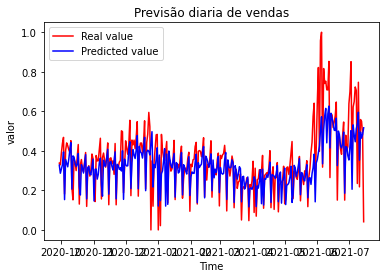

In [ ]:
# Visualising the results
plt.plot(normalized_df.loc[train_size:, 'Timestamp'],dataset_test.values, color = 'red', label = 'Real value')
plt.plot(normalized_df.loc[train_size:, 'Timestamp'],predicted_stock_price, color = 'blue', label = 'Predicted value')
plt.title('Previsão diaria de vendas')
plt.xlabel('Time')
plt.ylabel('valor')
plt.legend()
plt.show()

In [ ]:
dataset_test['predicted'] = predicted_stock_price
dataset_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Price,predicted
Timestamp,,
2020-09-29,0.337793,0.327730
2020-09-30,0.329513,0.286666
2020-10-01,0.390356,0.307933
2020-10-02,0.438152,0.329967
2020-10-03,0.468100,0.394427
...,...,...
2021-07-11,0.217814,0.353084
2021-07-12,0.558376,0.494973
2021-07-13,0.549577,0.464289


In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
obj1 = scaler.fit([y_test])
testY = obj1.inverse_transform([y_test])
testScore = math.sqrt(mean_squared_error(testY[0], predicted_stock_price[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.99 RMSE


In [ ]:
df2['predicted'] = df2['Price']
desnormalized = (dataset_test+df2.min())*(df2.max()+df2.min())
desnormalized

,Price,predicted
Timestamp,,
2020-09-29,2813.92,2730.098256
2020-09-30,2744.95,2388.021796
2020-10-01,3251.79,2565.177224
2020-10-02,3649.95,2748.729641
2020-10-03,3899.42,3285.705870
...,...,...
2021-07-11,1814.46,2941.304676
2021-07-12,4651.45,4123.282769
2021-07-13,4578.15,3867.674284
